In [17]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torchvision.models.detection.rpn import AnchorGenerator
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import SGD, AdamW, Adam, Adamax
from tqdm import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as patches
from sklearn.metrics import average_precision_score
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import SSD300_VGG16_Weights
from collections import defaultdict
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection import _utils

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [19]:
RAW_IMAGE_FOLDER = r"/kaggle/input/german-traffic-sign-detection-benchmark-gtsdb/FullIJCNN2013/"
ANNOTATIONS_FILE = r"/kaggle/input/german-traffic-sign-detection-benchmark-gtsdb/FullIJCNN2013/gt.txt"

IOU_THRESHOLDS = np.arange(0.5, 1.0, 0.05)

LABEL_TO_CLASS = {
    **dict.fromkeys([0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16], 1),
    **dict.fromkeys([11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 2),
    **dict.fromkeys([33, 34, 35, 36, 37, 38, 39, 40], 3),
    **dict.fromkeys([6, 12, 13, 14, 17, 32, 41, 42], 4)
}

CLASS_TO_CATEGORY = {
    1: "prohibitory",
    2: "danger",
    3: "mandatory",
    4: "other"
}

In [20]:
class TrafficSignDataset(Dataset):
    def __init__(self, image_folder, annotations_file, transforms=None):
        self.image_folder = image_folder
        self.transforms = transforms

        self.annotations = np.genfromtxt(annotations_file, delimiter=';', dtype=None, encoding='utf-8')

        self.annotation_dict = {}
        for entry in self.annotations:
            img_name = entry[0]
            bbox = [float(entry[1]), float(entry[2]), float(entry[3]), float(entry[4])]
            label = int(entry[5])
            mapped_label = LABEL_TO_CLASS[label]

            if img_name not in self.annotation_dict:
                self.annotation_dict[img_name] = []
            self.annotation_dict[img_name].append((bbox, mapped_label))

        self.img_names = sorted(self.annotation_dict.keys())

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.image_folder, img_name)

        img = Image.open(img_path).convert("RGB")

        annotations = self.annotation_dict[img_name]
        boxes = [ann[0] for ann in annotations]
        labels = [ann[1] for ann in annotations]

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)
        else:
            img = torchvision.transforms.ToTensor()(img)

        return img, target

    def __len__(self):
        return len(self.img_names)


In [21]:
def classify_bbox_sizes_and_classes(dataset):
    size_category_counts = {
        "small": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0},
        "medium": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0},
        "large": {"prohibitory": 0, "mandatory": 0, "danger": 0, "other": 0}
    }

    for _, target in dataset:
        boxes = target["boxes"]
        labels = target["labels"]
        done = False

        for box, label in zip(boxes, labels):
            width = box[2] - box[0]
            if width < 32:
                size_group = "small"
            elif 32 <= width <= 45:
                size_group = "medium"
            else:
                size_group = "large"
            # if not done:
            major_category = CLASS_TO_CATEGORY.get(label.item(), "other")
            size_category_counts[size_group][major_category] += 1
                # done = True

    return size_category_counts


def visualize_class_distribution(size_category_counts):
    categories = ["prohibitory", "mandatory", "danger", "other"]
    size_groups = ["small", "medium", "large"]
    width = 0.2
    x = np.arange(len(size_groups))

    bar_data = {cat: [size_category_counts[size][cat] for size in size_groups] for cat in categories}

    plt.figure(figsize=(12, 6))
    for i, category in enumerate(categories):
        plt.bar(x + i * width, bar_data[category], width, label=category)

    plt.title("Class Distribution by Size Category")
    plt.xlabel("Size Category")
    plt.ylabel("Frequency")
    plt.xticks(x + width * 1.5, size_groups)
    plt.legend(title="Class Group")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def visualize_class_distribution2(size_category_counts):
    categories = ["prohibitory", "mandatory", "danger", "other"]

    # Calculate the total count for each class
    total_counts = {cat: sum(size_category_counts[size][cat] for size in size_category_counts) for cat in categories}

    plt.figure(figsize=(8, 5))
    plt.bar(categories, total_counts.values(), color=['skyblue', 'orange', 'limegreen', 'red'], alpha=0.8)

    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Total Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def visualize_images_with_annotations(dataset, indices):
    num_images = len(indices)
    fig, axs = plt.subplots(1, num_images, figsize=(25, 15))

    if num_images == 1:
        axs = [axs]

    for ax, idx in zip(axs, indices):
        img, target = dataset[idx]

        img_np = img.permute(1, 2, 0).numpy()

        if img_np.max() > 1:
            img_np /= 255.0

        ax.imshow(img_np)
        
        for box, label in zip(target["boxes"].numpy(), target["labels"].numpy()):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            
            label_name = CLASS_TO_CATEGORY.get(label.item(), f"Unknown ({label.item()})")
            
            ax.text(xmin, ymin - 10, label_name, color="white", fontsize=15,
                    bbox=dict(facecolor='green', edgecolor='white', alpha=0.8))

        ax.axis("off")
        ax.set_title(f"Image {idx}")

    plt.tight_layout()
    plt.show()


def split_dataset(dataset, train_ratio=0.8, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    indices = torch.randperm(len(dataset)).tolist()
    train_size = int(len(dataset) * train_ratio)

    train_dataset = Subset(dataset, indices[:train_size])
    test_dataset = Subset(dataset, indices[train_size:])

    return train_dataset, test_dataset

def plot_class_distribution(dataset, title):
    label_counts = Counter()
    for _, target in dataset:
        label_counts.update(target["labels"].tolist())

    labels, counts = zip(*sorted(label_counts.items()))
    plt.bar(labels, counts, tick_label=[CLASS_TO_CATEGORY[label] for label in labels], color='blue')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Class Labels")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def visualize_size_distribution(size_category_counts):
    size_groups = ["small", "medium", "large"]
    
    total_counts = [sum(size_category_counts[size].values()) for size in size_groups]
    print(total_counts)
    plt.figure(figsize=(8, 5))
    plt.bar(size_groups, total_counts, color=['skyblue', 'orange', 'limegreen'], alpha=0.8)
    
    plt.title("Total Distribution by Size Category")
    plt.xlabel("Size Category")
    plt.ylabel("Total Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [23]:
transforms = None

dataset = TrafficSignDataset(RAW_IMAGE_FOLDER, ANNOTATIONS_FILE, transforms=transforms)
print(f"Number of images: {len(dataset)}")


Number of images: 741


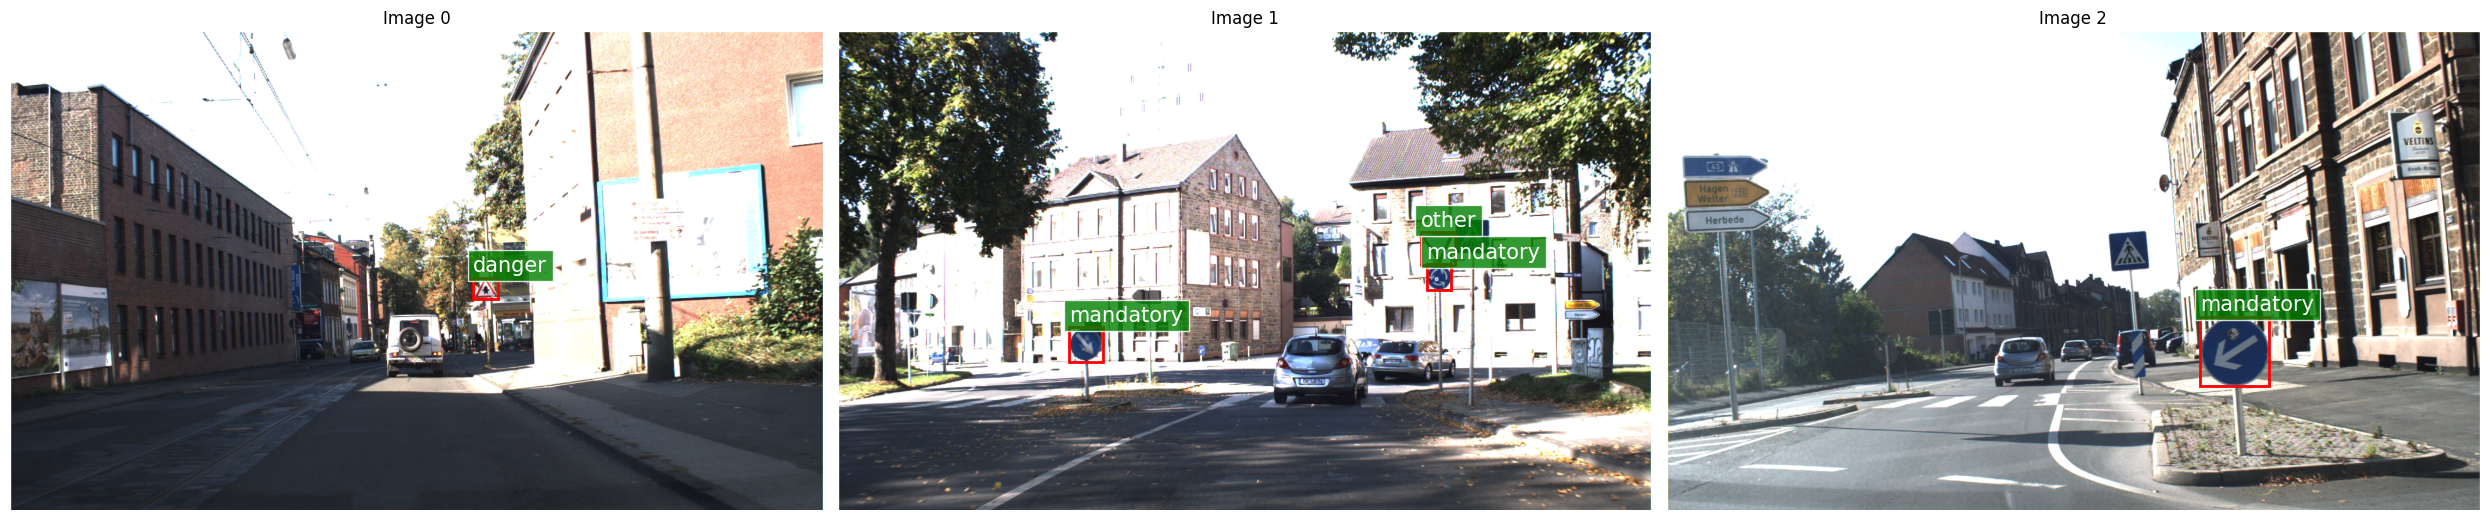

In [7]:
visualize_images_with_annotations(dataset, indices=[0, 1, 2])

[413, 388, 412]


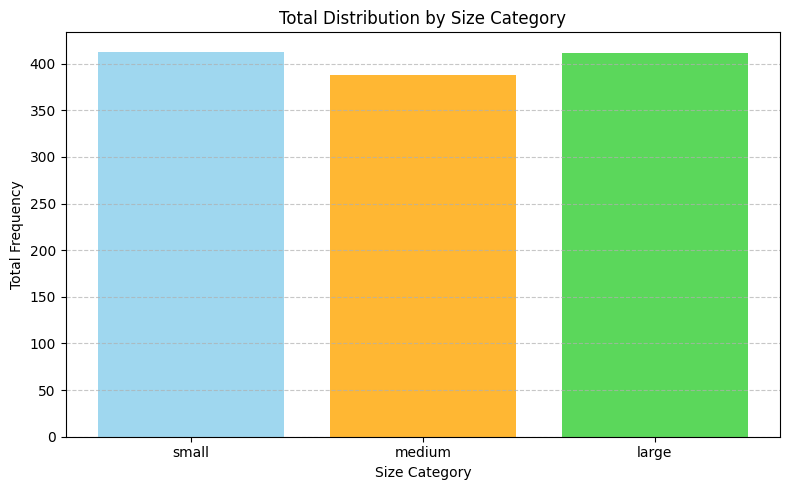

In [8]:
size_category_counts = classify_bbox_sizes_and_classes(dataset)
visualize_size_distribution(size_category_counts)

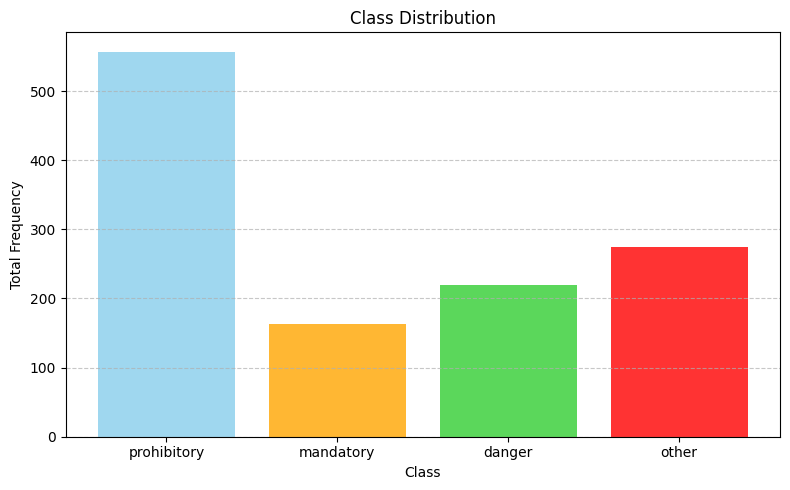

In [9]:
visualize_class_distribution2(size_category_counts)

Total dataset size: 741
Training dataset size: 592
test dataset size: 149
[330, 305, 328]


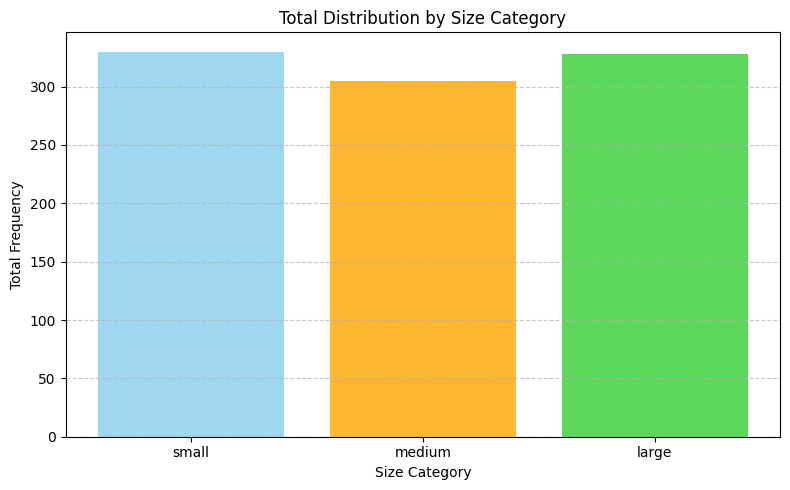

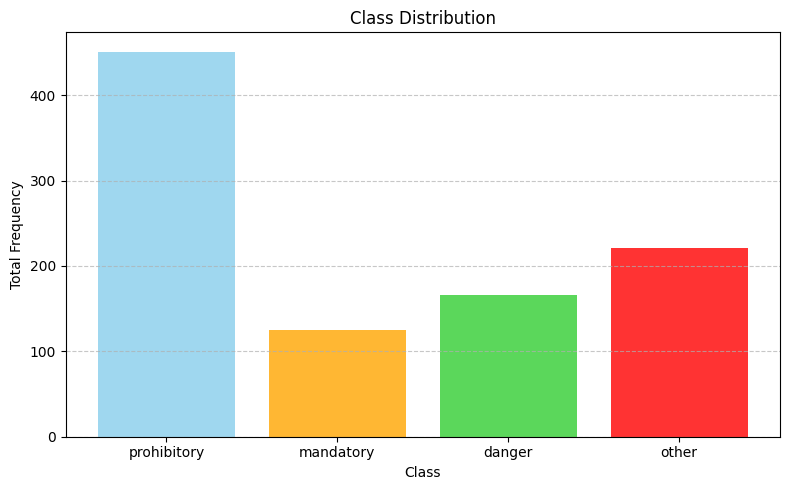

[83, 83, 84]


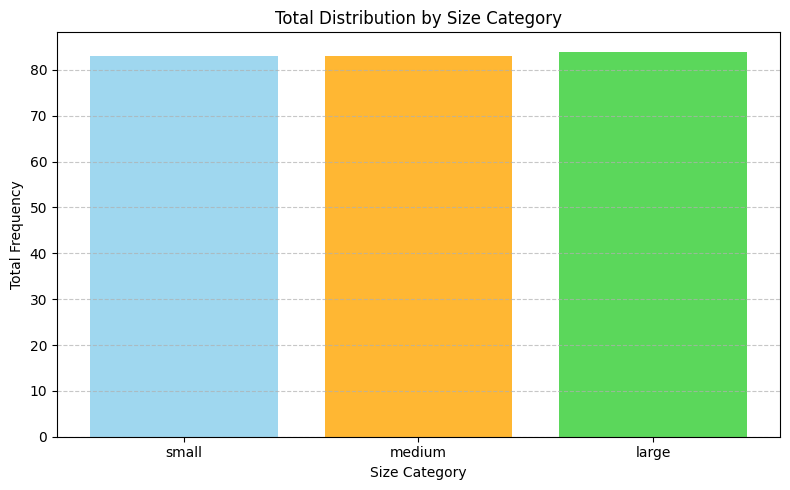

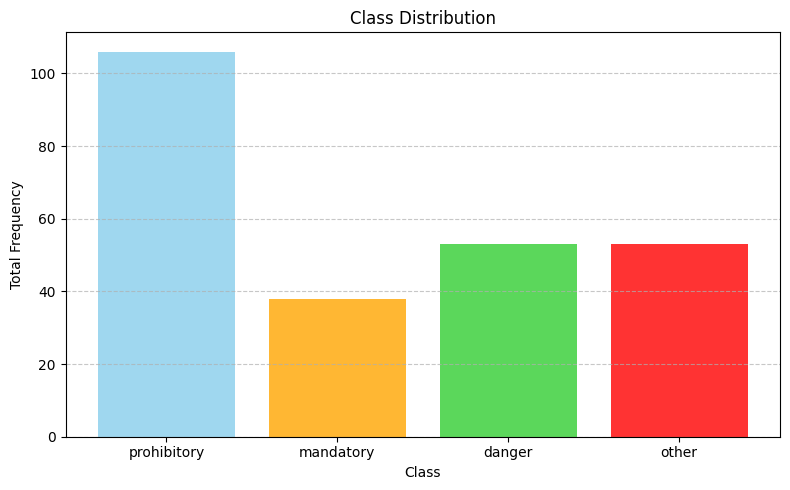

In [24]:
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.8)

print(f"Total dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"test dataset size: {len(test_dataset)}")

size_category_counts = classify_bbox_sizes_and_classes(train_dataset)
visualize_size_distribution(size_category_counts)
visualize_class_distribution2(size_category_counts)

size_category_counts = classify_bbox_sizes_and_classes(test_dataset)
visualize_size_distribution(size_category_counts)
visualize_class_distribution2(size_category_counts)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [26]:
def calculate_iou(true_boxes, pred_boxes, device):
    if len(true_boxes) == 0 or len(pred_boxes) == 0:
        return torch.zeros((len(true_boxes), len(pred_boxes)), device=device)

    true_boxes = true_boxes.unsqueeze(1).to(device)
    pred_boxes = pred_boxes.unsqueeze(0).to(device)

    inter_min = torch.max(true_boxes[..., :2], pred_boxes[..., :2])
    inter_max = torch.min(true_boxes[..., 2:], pred_boxes[..., 2:])
    inter = (inter_max - inter_min).clamp(0).prod(2)

    true_area = (true_boxes[..., 2] - true_boxes[..., 0]) * (true_boxes[..., 3] - true_boxes[..., 1])
    pred_area = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
    union = true_area + pred_area - inter

    iou = inter / (union + 1e-6)
    return iou

In [27]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights="COCO_V1")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    
    iou_thresholds = torch.linspace(0.5, 0.95, 10).to(device)
    all_ap50 = []
    all_ap50_95 = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for i in range(len(targets)):
                true_boxes = targets[i]["boxes"]
                pred_boxes = outputs[i]["boxes"]
                pred_scores = outputs[i]["scores"]

                if len(true_boxes) == 0 or len(pred_boxes) == 0:
                    all_ap50.append(0)
                    all_ap50_95.append(0)
                    continue

                iou = calculate_iou(true_boxes, pred_boxes, device)

                ap50 = []
                for t in iou_thresholds:
                    tp = (iou.max(dim=1).values >= t).sum().item()
                    fp = len(pred_boxes) - tp
                    fn = len(true_boxes) - tp

                    precision = tp / (tp + fp + 1e-6)
                    recall = tp / (tp + fn + 1e-6)

                    ap50.append(precision * recall)

                all_ap50.append(ap50[0])
                all_ap50_95.append(torch.mean(torch.tensor(ap50)).item())

    metrics = {
        "mAP50": sum(all_ap50) / len(all_ap50),
        "mAP50-95": sum(all_ap50_95) / len(all_ap50_95),
    }
    return metrics


def fine_tune_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device, num_classes):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, targets in tqdm(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()

        val_metrics = evaluate(model, test_loader, device, num_classes)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {running_loss / len(train_loader):.4f}")
        print(f"Validation Metrics: {val_metrics}")
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), f"{type(model).__name__}.pt")
    print("Training and evaluation completed.")
    # torch.save(model.state_dict(), "fasterrcnn_resnet50.pth")


In [47]:
num_classes = 4 + 1
frcnn_resnet = get_model(num_classes).to(device)
optimizer = AdamW(frcnn_resnet.parameters(), lr=0.0001)
num_epochs = 10
fine_tune_and_evaluate(frcnn_resnet, train_loader, test_loader, optimizer, num_epochs, device, num_classes=num_classes)

100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 1/10
Training Loss: 0.1873
Validation Metrics: {'mAP50': 0.3325891279536645, 'mAP50-95': 0.23445813000302188}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 2/10
Training Loss: 0.0878
Validation Metrics: {'mAP50': 0.31678906402265905, 'mAP50-95': 0.25617676853333543}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 3/10
Training Loss: 0.0610
Validation Metrics: {'mAP50': 0.5873697505556645, 'mAP50-95': 0.4909892866775494}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 4/10
Training Loss: 0.0538
Validation Metrics: {'mAP50': 0.7415705055318895, 'mAP50-95': 0.5910085547690423}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 5/10
Training Loss: 0.0432
Validation Metrics: {'mAP50': 0.8295570016170326, 'mAP50-95': 0.6864882504580004}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 6/10
Training Loss: 0.0426
Validation Metrics: {'mAP50': 0.8826928876799824, 'mAP50-95': 0.7669872694567546}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 7/10
Training Loss: 0.0377
Validation Metrics: {'mAP50': 0.8222423753593832, 'mAP50-95': 0.7003844453384412}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 8/10
Training Loss: 0.0337
Validation Metrics: {'mAP50': 0.8268551109805223, 'mAP50-95': 0.6950258914656287}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 9/10
Training Loss: 0.0318
Validation Metrics: {'mAP50': 0.8902352094109554, 'mAP50-95': 0.7747137560540398}


100%|██████████| 296/296 [01:43<00:00,  2.86it/s]


Epoch 10/10
Training Loss: 0.0299
Validation Metrics: {'mAP50': 0.9021985147301473, 'mAP50-95': 0.7826386432119664}
Training and evaluation completed.


In [15]:
frcnn_resnet = get_model(num_classes).to(device)
frcnn_resnet.load_state_dict(torch.load(f"/kaggle/working/{type(frcnn_resnet).__name__}.pt"))

/tmp/ipykernel_23/3499171783.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frcnn_resnet.load_state_dict(torch.load(f"/kaggle/working/{type(frcnn_resnet).__name__}.pt")

<All keys matched successfully>

In [16]:
def calculate_ap(detections, ground_truths, iou_threshold, device):
    if len(detections) == 0 or len(ground_truths) == 0:
        return 0.0

    detections = sorted(detections, key=lambda x: x[4], reverse=True)
    pred_boxes = torch.tensor([det[:4] for det in detections], device=device)
    pred_scores = torch.tensor([det[4] for det in detections], device=device)
    true_boxes = torch.tensor(ground_truths, device=device)

    iou_matrix = calculate_iou(true_boxes, pred_boxes, device)
    matched_gt = set()
    tp = []
    fp = []

    for pred_idx in range(len(pred_boxes)):
        max_iou, gt_idx = iou_matrix[:, pred_idx].max(0)

        if max_iou >= iou_threshold and gt_idx.item() not in matched_gt:
            tp.append(1)
            fp.append(0)
            matched_gt.add(gt_idx.item())
        else:
            tp.append(0)
            fp.append(1)

    tp = torch.cumsum(torch.tensor(tp, device=device), dim=0)
    fp = torch.cumsum(torch.tensor(fp, device=device), dim=0)
    precisions = tp / (tp + fp + 1e-6)
    recalls = tp / len(ground_truths)

    ap = torch.sum((recalls[1:] - recalls[:-1]) * precisions[1:]).item()
    return ap

In [38]:
def evaluate_model_class_separated(model, dataloader, device, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    model.eval()
    results = defaultdict(list)
    ground_truths_per_class = defaultdict(list)

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                boxes = output['boxes'].to(device)  
                scores = output['scores'].to(device)
                labels = output['labels'].to(device)

                gt_boxes = targets[i]['boxes'].to(device)
                gt_labels = targets[i]['labels'].to(device)

                for class_id in torch.cat([labels, gt_labels]).unique():
                    ground_truths = gt_boxes[gt_labels == class_id].tolist()
                    detections = [
                        [*boxes[j].tolist(), scores[j].item()]
                        for j in range(len(labels))
                        if labels[j] == class_id
                    ]

                    results[class_id.item()].append(detections)
                    ground_truths_per_class[class_id.item()].append(ground_truths)

    ap_results = {class_id: [] for class_id in results.keys()}

    for iou_threshold in iou_thresholds:
        for class_id in results.keys():
            detections = [det for img_dets in results[class_id] for det in img_dets]
            ground_truths = [
                gt for img_gts in ground_truths_per_class[class_id] for gt in img_gts
            ]

            ap = calculate_ap(detections, ground_truths, iou_threshold, device)
            ap_results[class_id].append(ap)

    return ap_results, iou_thresholds

def plot_ap_with_map(ap_results, iou_thresholds):
    plt.figure(figsize=(10, 6))

    for class_id, ap_values in ap_results.items():
        if class_id == 0:  # Skip the background class
            continue
        label = CLASS_TO_CATEGORY.get(class_id, f"Unknown ({class_id})")
        plt.plot(
            iou_thresholds, ap_values, label=f"{label} AP", linestyle='--', marker='o'
        )

    num_classes = len([cls for cls in ap_results.keys() if cls != 0])
    mAP = [sum(ap_values) / num_classes for ap_values in zip(*ap_results.values())]

    plt.plot(iou_thresholds, mAP, label="mAP", linestyle='-', marker='x', color='black')

    plt.axvline(x=0.75, color='purple', linestyle='--', label='IoU = 0.75')

    plt.title("AP of SSD300-VGG16 Across IoU Thresholds", fontsize=14)
    plt.xlabel("Intersection over Union (IoU)", fontsize=12)
    plt.ylabel("Average Precision (AP)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


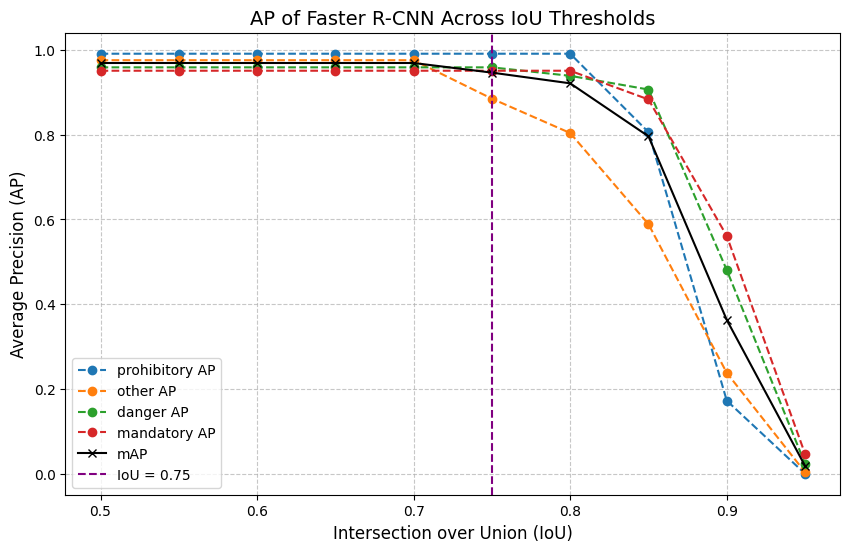

In [18]:
ap_results, iou_thresholds = evaluate_model_class_separated(frcnn_resnet, test_loader, device)
plot_ap_with_map(ap_results, iou_thresholds)

In [42]:
def evaluate_model_by_size(model, data_loader, device):
    model.eval()
    size_metrics = {
        'small': {'true_labels': [], 'pred_scores': []},
        'medium': {'true_labels': [], 'pred_scores': []},
        'large': {'true_labels': [], 'pred_scores': []}
    }

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                true_boxes = target["boxes"]
                pred_boxes = output["boxes"]
                pred_scores = output["scores"]

                for box, score in zip(pred_boxes, pred_scores):
                    width = box[2] - box[0]
                    if width < 32:
                        size_group = "small"
                    elif 32 <= width <= 45:
                        size_group = "medium"
                    else:
                        size_group = "large"

                    ious = [calculate_iou(box.unsqueeze(0), true_box.unsqueeze(0), device) for true_box in true_boxes]
                    max_iou = max(ious) if ious else 0
                    true_label = 1 if max_iou >= 0.5 else 0

                    size_metrics[size_group]['true_labels'].append(true_label)
                    size_metrics[size_group]['pred_scores'].append(score.item())

    for size in size_metrics:
        true_labels = size_metrics[size]['true_labels']
        pred_scores = size_metrics[size]['pred_scores']
        size_metrics[size]['mAP'] = average_precision_score(true_labels, pred_scores)

    return size_metrics
def evaluate_model_by_size2(model, data_loader, device):
    model.eval()
    size_metrics = {
        'small': {'true_labels': [], 'pred_scores': []},
        'medium': {'true_labels': [], 'pred_scores': []},
        'large': {'true_labels': [], 'pred_scores': []}
    }

    results_by_size = {
        'small': [],
        'medium': [],
        'large': []
    }
    ground_truths_by_size = {
        'small': [],
        'medium': [],
        'large': []
    }

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                pred_boxes = output["boxes"]
                pred_scores = output["scores"]
                true_boxes = target["boxes"]

                for box, score in zip(pred_boxes, pred_scores):
                    width = box[2] - box[0]
                    if width < 32:
                        size_group = "small"
                    elif 32 <= width <= 45:
                        size_group = "medium"
                    else:
                        size_group = "large"

                    results_by_size[size_group].append([*box.tolist(), score.item()])
                for true_box in true_boxes:
                    width = true_box[2] - true_box[0]
                    if width < 32:
                        size_group = "small"
                    elif 32 <= width <= 45:
                        size_group = "medium"
                    else:
                        size_group = "large"

                    ground_truths_by_size[size_group].append(true_box.tolist())

    for size in size_metrics:
        detections = results_by_size[size]
        ground_truths = ground_truths_by_size[size]

        if detections and ground_truths:
            ap = calculate_ap(detections, ground_truths, iou_threshold=0.5, device=device)
        else:
            ap = 0

        size_metrics[size]['mAP'] = ap

    return size_metrics


def plot_evaluation_results(size_metrics):
    sizes = list(size_metrics.keys())
    mAPs = [size_metrics[size]['mAP'] for size in sizes]

    plt.figure(figsize=(10, 6))
    plt.bar(sizes, mAPs, color=['blue', 'orange', 'green'])

    plt.xlabel('Object Size')
    plt.ylabel('mAP')
    plt.title('Model Evaluation (mAP) for Different Object Sizes')
    plt.show()

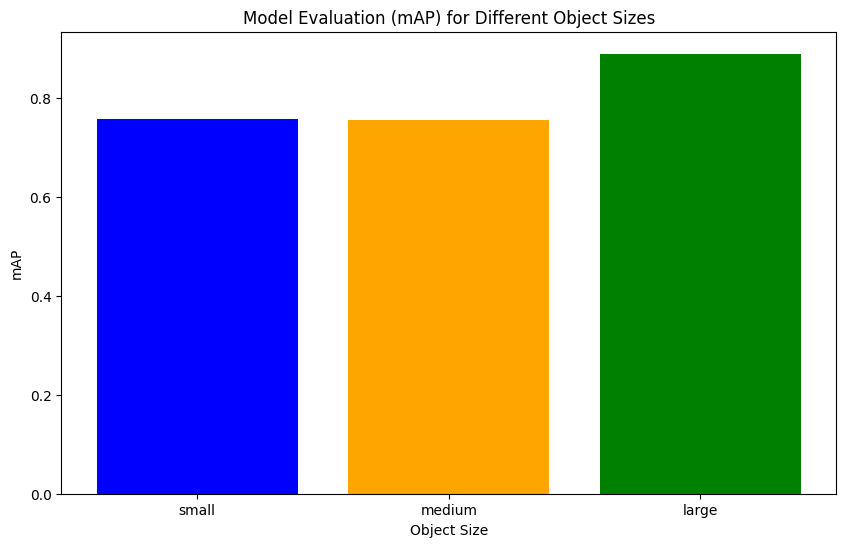

In [48]:
size_metrics = evaluate_model_by_size2(frcnn_resnet, test_loader, device)
plot_evaluation_results(size_metrics)

In [36]:
def visualize_images_with_predictions_and_annotations(dataset, indices, model, device, idx_to_class=None):
    num_images = len(indices)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axs = [axs]

    model.eval()

    for ax, idx in zip(axs, indices):
        img, target = dataset[idx]
        img = img.to(device)
        img_np = img.permute(1, 2, 0).cpu().numpy()

        if img_np.max() > 1:
            img_np /= 255.0

        with torch.no_grad():
            prediction = model([img])

        pred_boxes = prediction[0]["boxes"].cpu().numpy()
        pred_labels = prediction[0]["labels"].cpu().numpy()
        pred_scores = prediction[0]["scores"].cpu().numpy()

        target_boxes = target["boxes"].numpy()
        target_labels = target["labels"].numpy()

        ax.imshow(img_np)

        for box, label in zip(target_boxes, target_labels):
            xmin, ymin, xmax, ymax = box
            label_text = f"GT: {idx_to_class[label]}" if idx_to_class else f"GT: {label}"
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='green', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 50, label_text, color="yellow", 
                    bbox=dict(facecolor='green', edgecolor='green', alpha=0.7))

        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            xmin, ymin, xmax, ymax = box
            label_text = f"Pred: {idx_to_class[label]} ({score:.2f})" if idx_to_class else f"Pred: {label} ({score:.2f})"
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymax + 50, label_text, color="yellow", 
                    bbox=dict(facecolor='red', edgecolor='red', alpha=0.7))

        ax.axis("off")
        ax.set_title(f"Image {idx}")

    plt.tight_layout()
    plt.show()


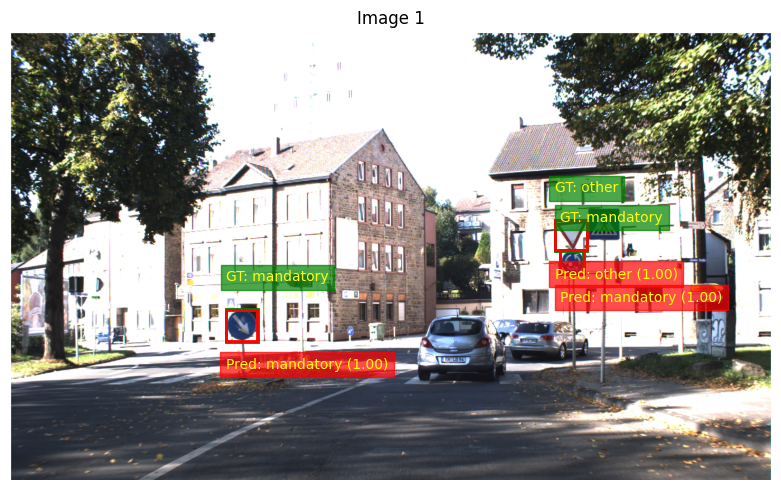

In [22]:
sample_indices = [1]
visualize_images_with_predictions_and_annotations(
    dataset=dataset,
    indices=sample_indices,
    model=frcnn_resnet,
    device=device,
    idx_to_class=CLASS_TO_CATEGORY
)

In [28]:
def create_SSD_model(num_classes=5, size=300):
    model = torchvision.models.detection.ssd300_vgg16(
        weights=SSD300_VGG16_Weights.COCO_V1
    )
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    num_anchors = model.anchor_generator.num_anchors_per_location()
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
    )
    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model


In [29]:
num_classes = 4 + 1
SSD = create_SSD_model().to(device)
optimizer = AdamW(SSD.parameters(), lr=0.0001)
num_epochs = 40
fine_tune_and_evaluate(SSD, train_loader, test_loader, optimizer, num_epochs, device, num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 79.0MB/s] 
100%|██████████| 296/296 [00:24<00:00, 12.33it/s]


Epoch 1/40
Training Loss: 5.8105
Validation Metrics: {'mAP50': 0.006895968806407073, 'mAP50-95': 0.0037444046106276997}


100%|██████████| 296/296 [00:23<00:00, 12.86it/s]


Epoch 2/40
Training Loss: 3.7565
Validation Metrics: {'mAP50': 0.007052568231891911, 'mAP50-95': 0.004119963627371112}


100%|██████████| 296/296 [00:23<00:00, 12.79it/s]


Epoch 3/40
Training Loss: 3.2176
Validation Metrics: {'mAP50': 0.006937915031728768, 'mAP50-95': 0.004008106888512512}


100%|██████████| 296/296 [00:22<00:00, 12.87it/s]


Epoch 4/40
Training Loss: 2.7951
Validation Metrics: {'mAP50': 0.007318228071400739, 'mAP50-95': 0.004281317005746517}


100%|██████████| 296/296 [00:23<00:00, 12.85it/s]


Epoch 5/40
Training Loss: 2.4815
Validation Metrics: {'mAP50': 0.007362970771587184, 'mAP50-95': 0.004154639300615245}


100%|██████████| 296/296 [00:22<00:00, 12.93it/s]


Epoch 6/40
Training Loss: 2.2364
Validation Metrics: {'mAP50': 0.007491606157316045, 'mAP50-95': 0.004501395177521162}


100%|██████████| 296/296 [00:23<00:00, 12.83it/s]


Epoch 7/40
Training Loss: 1.9672
Validation Metrics: {'mAP50': 0.007390935036454744, 'mAP50-95': 0.004406596612085232}


100%|██████████| 296/296 [00:23<00:00, 12.79it/s]


Epoch 8/40
Training Loss: 1.7724
Validation Metrics: {'mAP50': 0.015107080449063559, 'mAP50-95': 0.009203531139845891}


100%|██████████| 296/296 [00:22<00:00, 13.12it/s]


Epoch 9/40
Training Loss: 1.4424
Validation Metrics: {'mAP50': 0.016964168815264927, 'mAP50-95': 0.010748991400320646}


100%|██████████| 296/296 [00:23<00:00, 12.80it/s]


Epoch 10/40
Training Loss: 1.1242
Validation Metrics: {'mAP50': 0.1609752065545648, 'mAP50-95': 0.10973810212414761}


100%|██████████| 296/296 [00:22<00:00, 13.04it/s]


Epoch 11/40
Training Loss: 0.9098
Validation Metrics: {'mAP50': 0.11721786683791821, 'mAP50-95': 0.0744690679704408}


100%|██████████| 296/296 [00:23<00:00, 12.86it/s]


Epoch 12/40
Training Loss: 0.7941
Validation Metrics: {'mAP50': 0.29574790819747593, 'mAP50-95': 0.19241536362096667}


100%|██████████| 296/296 [00:23<00:00, 12.86it/s]


Epoch 13/40
Training Loss: 0.6736
Validation Metrics: {'mAP50': 0.34398701160923834, 'mAP50-95': 0.23755924121457958}


100%|██████████| 296/296 [00:22<00:00, 12.90it/s]


Epoch 14/40
Training Loss: 0.5115
Validation Metrics: {'mAP50': 0.5071261844200967, 'mAP50-95': 0.3291263189791833}


100%|██████████| 296/296 [00:22<00:00, 12.93it/s]


Epoch 15/40
Training Loss: 0.3454
Validation Metrics: {'mAP50': 0.5318896419019882, 'mAP50-95': 0.36362093037319365}


100%|██████████| 296/296 [00:22<00:00, 12.92it/s]


Epoch 16/40
Training Loss: 0.2570
Validation Metrics: {'mAP50': 0.5529295404166396, 'mAP50-95': 0.3586605736585772}


100%|██████████| 296/296 [00:23<00:00, 12.86it/s]


Epoch 17/40
Training Loss: 0.2339
Validation Metrics: {'mAP50': 0.6251801775558345, 'mAP50-95': 0.4340325775462509}


100%|██████████| 296/296 [00:23<00:00, 12.86it/s]


Epoch 18/40
Training Loss: 0.1960
Validation Metrics: {'mAP50': 0.6489044441444038, 'mAP50-95': 0.43549817000459506}


100%|██████████| 296/296 [00:23<00:00, 12.76it/s]


Epoch 19/40
Training Loss: 0.1698
Validation Metrics: {'mAP50': 0.6254944602270892, 'mAP50-95': 0.4254935808079755}


100%|██████████| 296/296 [00:22<00:00, 12.94it/s]


Epoch 20/40
Training Loss: 0.1698
Validation Metrics: {'mAP50': 0.6339289759214912, 'mAP50-95': 0.436077826500139}


100%|██████████| 296/296 [00:22<00:00, 12.87it/s]


Epoch 21/40
Training Loss: 0.1522
Validation Metrics: {'mAP50': 0.6259125619984467, 'mAP50-95': 0.41143673738377207}


100%|██████████| 296/296 [00:22<00:00, 13.03it/s]


Epoch 22/40
Training Loss: 0.1447
Validation Metrics: {'mAP50': 0.6668947041191535, 'mAP50-95': 0.4394165973035281}


100%|██████████| 296/296 [00:23<00:00, 12.72it/s]


Epoch 23/40
Training Loss: 0.5302
Validation Metrics: {'mAP50': 0.26122185451912006, 'mAP50-95': 0.15532472565607636}


100%|██████████| 296/296 [00:23<00:00, 12.76it/s]


Epoch 24/40
Training Loss: 0.5767
Validation Metrics: {'mAP50': 0.46286389654137133, 'mAP50-95': 0.3089421584752182}


100%|██████████| 296/296 [00:22<00:00, 12.90it/s]


Epoch 25/40
Training Loss: 0.1993
Validation Metrics: {'mAP50': 0.608854420849089, 'mAP50-95': 0.43463300726057696}


100%|██████████| 296/296 [00:23<00:00, 12.83it/s]


Epoch 26/40
Training Loss: 1.1056
Validation Metrics: {'mAP50': 0.2475580849130866, 'mAP50-95': 0.15434833013783866}


100%|██████████| 296/296 [00:22<00:00, 13.00it/s]


Epoch 27/40
Training Loss: 0.3867
Validation Metrics: {'mAP50': 0.5633035035667404, 'mAP50-95': 0.3790984673413054}


100%|██████████| 296/296 [00:22<00:00, 12.88it/s]


Epoch 28/40
Training Loss: 0.1568
Validation Metrics: {'mAP50': 0.6369584122268315, 'mAP50-95': 0.43129129160270596}


100%|██████████| 296/296 [00:23<00:00, 12.77it/s]


Epoch 29/40
Training Loss: 0.0897
Validation Metrics: {'mAP50': 0.6523946137723865, 'mAP50-95': 0.45988369913109195}


100%|██████████| 296/296 [00:22<00:00, 12.90it/s]


Epoch 30/40
Training Loss: 0.0690
Validation Metrics: {'mAP50': 0.6528154014641386, 'mAP50-95': 0.4559609939237969}


100%|██████████| 296/296 [00:22<00:00, 12.90it/s]


Epoch 31/40
Training Loss: 0.0551
Validation Metrics: {'mAP50': 0.6671224028539514, 'mAP50-95': 0.46466836785810106}


100%|██████████| 296/296 [00:22<00:00, 12.93it/s]


Epoch 32/40
Training Loss: 0.0454
Validation Metrics: {'mAP50': 0.65026002161135, 'mAP50-95': 0.46237344621061877}


100%|██████████| 296/296 [00:22<00:00, 12.92it/s]


Epoch 33/40
Training Loss: 0.0484
Validation Metrics: {'mAP50': 0.6511641731814415, 'mAP50-95': 0.4574592038113999}


100%|██████████| 296/296 [00:23<00:00, 12.85it/s]


Epoch 34/40
Training Loss: 0.0534
Validation Metrics: {'mAP50': 0.6597212093755259, 'mAP50-95': 0.468917048329975}


100%|██████████| 296/296 [00:23<00:00, 12.76it/s]


Epoch 35/40
Training Loss: 0.0652
Validation Metrics: {'mAP50': 0.658882297812296, 'mAP50-95': 0.46049518665711353}


100%|██████████| 296/296 [00:22<00:00, 12.92it/s]


Epoch 36/40
Training Loss: 0.0784
Validation Metrics: {'mAP50': 0.632623947205422, 'mAP50-95': 0.4455045240387421}


100%|██████████| 296/296 [00:22<00:00, 12.89it/s]


Epoch 37/40
Training Loss: 0.1057
Validation Metrics: {'mAP50': 0.6711132843336138, 'mAP50-95': 0.46956449134537837}


100%|██████████| 296/296 [00:22<00:00, 13.04it/s]


Epoch 38/40
Training Loss: 0.1106
Validation Metrics: {'mAP50': 0.6066638974911941, 'mAP50-95': 0.4244410003966733}


100%|██████████| 296/296 [00:22<00:00, 12.96it/s]


Epoch 39/40
Training Loss: 0.8185
Validation Metrics: {'mAP50': 0.40908940324018994, 'mAP50-95': 0.27656109544179786}


100%|██████████| 296/296 [00:22<00:00, 12.90it/s]


Epoch 40/40
Training Loss: 0.1955
Validation Metrics: {'mAP50': 0.6526649322119941, 'mAP50-95': 0.4503174782949406}
Training and evaluation completed.


In [32]:
SSD = create_SSD_model().to(device) 
SSD.load_state_dict(torch.load(f"/kaggle/working/{type(SSD).__name__}.pt"))

/tmp/ipykernel_23/1828378472.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  SSD.load_state_dict(torch.load(f"/kaggle/working/{type(SSD).__name__}.pt"))


<All keys matched successfully>

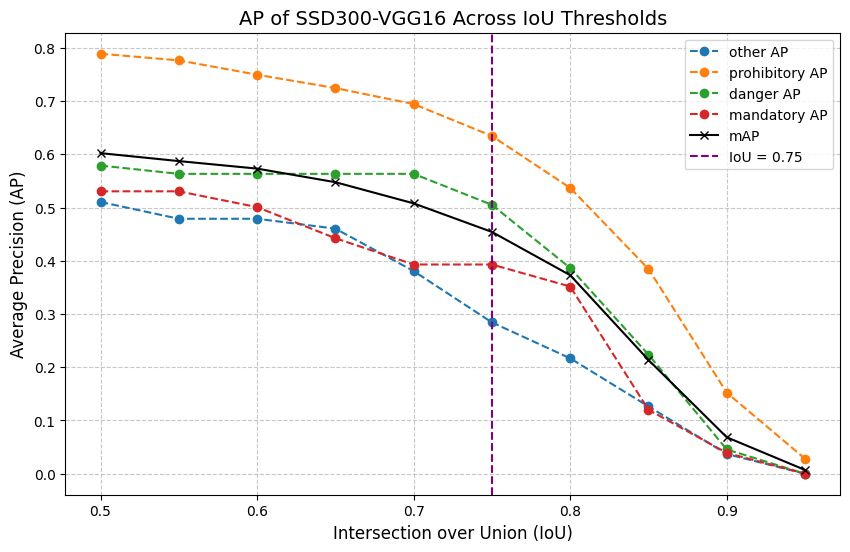

In [39]:
ap_results, iou_thresholds = evaluate_model_class_separated(SSD, test_loader, device)
plot_ap_with_map(ap_results, iou_thresholds)

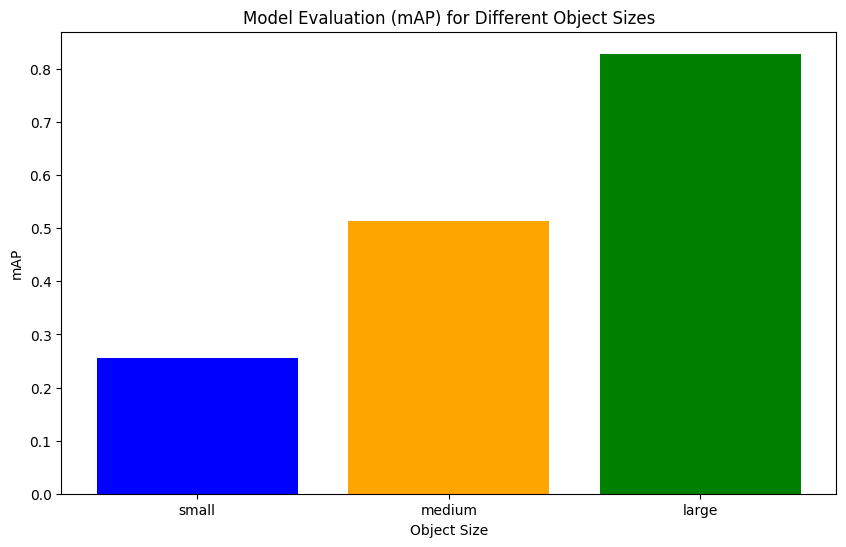

In [49]:
size_metrics = evaluate_model_by_size2(SSD, test_loader, device)
plot_evaluation_results(size_metrics)

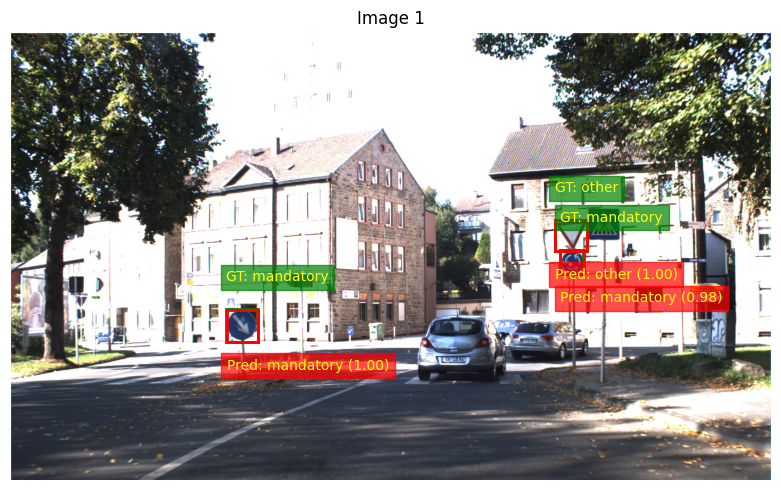

In [37]:
sample_indices = [1]
visualize_images_with_predictions_and_annotations(
    dataset=dataset,
    indices=sample_indices,
    model=SSD,
    device=device,
    idx_to_class=CLASS_TO_CATEGORY
)